<a href="https://colab.research.google.com/github/Tonyjoyy/trading_strategy/blob/main/ETF_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import yfinance as yf
import re
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Data download function
def download_data(symbol, start_date, end_date):
    return yf.download(symbol, start=start_date, end=end_date)

# RSI calculation
def calculate_rsi(prices, window):
    delta = prices.diff(1)
    gain = delta.clip(lower=0).rolling(window=window).mean()
    loss = -delta.clip(upper=0).rolling(window=window).mean()
    rs = gain / loss.replace(0, np.finfo(float).eps)
    return 100 - (100 / (1 + rs))

# Sanitize feature names
def sanitize_feature_names(df):
    df.columns = [re.sub(r'[^A-Za-z0-9_]+', '', str(col)) for col in df.columns]
    return df

# Compute features
def compute_features(data_etf, data_sp500):
    data_etf = data_etf.reset_index()
    data_sp500 = data_sp500.reset_index()

    if 'Close' not in data_etf.columns or 'Close' not in data_sp500.columns:
        raise KeyError("The 'Close' column is missing in the downloaded data.")

    df = data_etf[['Date', 'Close']].rename(columns={"Close": "Price"}).copy()
    df['sp500price'] = data_sp500['Close']

    for i in range(1, 6):
        df[f'Return_{i}'] = df['Price'].pct_change(i)

    df['RSI_6'] = calculate_rsi(df['Price'], 6)
    df['RSI_12'] = calculate_rsi(df['Price'], 12)
    df['RSI_24'] = calculate_rsi(df['Price'], 24)

    for ma in [20, 50, 100, 200]:
        df[f'MA{ma}_Price'] = df['Price'].rolling(window=ma).mean() / df['Price']
        df[f'MA{ma}_Bigger'] = (df['Price'].rolling(window=ma).mean() - df['Price']) / df['Price']

    sp500_returns = data_sp500['Close'].pct_change()
    df['SP500_5Day_Mean_Return'] = sp500_returns.rolling(window=5).mean()

    ema_short = df['Price'].ewm(span=12, adjust=False).mean()
    ema_long = df['Price'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_short - ema_long
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Histogram'] = df['MACD'] - df['Signal_Line']

    df['High20_to_Price'] = df['Price'].rolling(window=20).max() / df['Price']
    df['Low20_to_Price'] = df['Price'].rolling(window=20).min() / df['Price']
    df['High5_to_Price'] = df['Price'].rolling(window=5).max() / df['Price']
    df['Low5_to_Price'] = df['Price'].rolling(window=5).min() / df['Price']

    df = sanitize_feature_names(df)
    return df.dropna()

# Preprocess data (ensure index is preserved)
def preprocess_data(df):
    df = df.copy()  # Avoid modifying the input directly
    df['Target'] = df['PriceXLF'].pct_change(5).shift(-5)
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    for lag in range(1, 6):
        df[f'Lag_{lag}'] = df['Target'].shift(lag)
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    X = df.drop(columns=['Target', 'PriceXLF', 'sp500price'])
    y = df['Target']
    feature_columns = X.columns.tolist()
    return X, y, feature_columns

# Download and prepare data
start_date, end_date = "2010-01-01", "2024-12-31"
etf_symbol, sp500_symbol = "XLF", "^GSPC"
data_etf = download_data(etf_symbol, start_date, end_date)
data_sp500 = download_data(sp500_symbol, start_date, end_date)

df_features = compute_features(data_etf, data_sp500)

# Set Date as index early and ensure chronological order
df_features['Date'] = pd.to_datetime(df_features['Date'])
df_features.set_index('Date', inplace=True)
df_features = df_features.sort_index()

# Preprocess with the indexed DataFrame
X, y, feature_columns = preprocess_data(df_features)

# Verify lengths and index type
print(f"Length of X: {len(X)}, Length of y: {len(y)}")
print(f"X index type: {type(X.index)}")

# Split data based on time periods (train: 2010-2019, test: 2020-2024)
train_end = pd.to_datetime("2019-12-31")
test_start = pd.to_datetime("2020-01-01")

X_train = X[X.index <= train_end]
y_train = y[y.index <= train_end]

X_test = X[X.index >= test_start]
y_test = y[y.index >= test_start]

# Print sizes to debug
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train LightGBM Model
model = lgb.LGBMRegressor(
    num_leaves=35,
    learning_rate=0.05,
    n_estimators=100,
    lambda_l1=0.1,
    lambda_l2=0.1,
    random_state=42
)
model.fit(X_train_scaled, y_train)

# Evaluate Model
y_pred_test = model.predict(X_test_scaled)

print(f"Test Mean Squared Error: {mean_squared_error(y_test, y_pred_test):.6f}")
print(f"Test R²: {r2_score(y_test, y_pred_test):.4f}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Length of X: 3564, Length of y: 3564
X index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Training set size: 2312
Test set size: 1252
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 29
[LightGBM] [Info] Start training from score 0.002746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

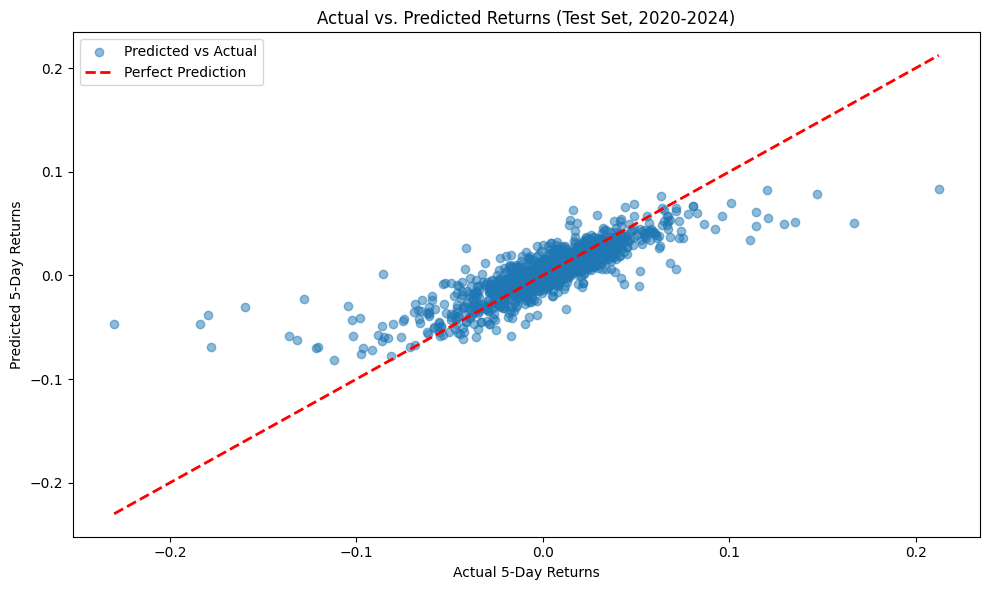

In [17]:
import matplotlib.pyplot as plt
# Visualization: Actual vs. Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5, label='Predicted vs Actual')  # Changed y_pred to y_pred_test
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel("Actual 5-Day Returns")
plt.ylabel("Predicted 5-Day Returns")
plt.title("Actual vs. Predicted Returns (Test Set, 2020-2024)")
plt.legend()
plt.tight_layout()
plt.show()